# Классификация новостей BBC без трансформеров
Кейс: классификация сообщений Telegram на основе открытого корпуса BBC.

## План работы
1. Исследовать датасет: покрытие, структура, качество и транскрипции.
2. Выполнить продвинутую предобработку: очистка, лемматизация, учёт сущностей NER.
3. Построить базовый конвейер TF-IDF + Logistic Regression и оценить качество.
4. Добавить альтернативные модели (SVM, Multinomial NB), подобрать веса ансамбля.
5. Оценить качество на тесте, разобрать ошибки и сформулировать выводы.

In [1]:
import sys
import subprocess

def ensure_package(package: str) -> None:
    try:
        __import__(package)
    except ImportError:
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', package])

for pkg in ('spacy', 'tqdm'):
    ensure_package(pkg)

import spacy
try:
    spacy.load('en_core_web_sm')
except OSError:
    subprocess.check_call([sys.executable, '-m', 'spacy', 'download', 'en_core_web_sm'])

print('Среда готова: spaCy и модель en_core_web_sm доступны.')

Среда готова: spaCy и модель en_core_web_sm доступны.


In [2]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.auto import tqdm
import spacy

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.base import clone

plt.style.use('seaborn-v0_8-whitegrid')
SEED = 42
rng = np.random.default_rng(SEED)

In [3]:
DATA_PATH = Path('bbc_news_text_complexity_summarization.csv')
df = pd.read_csv(DATA_PATH)
df.head()

,text,labels,no_sentences,Flesch Reading Ease Score,Dale-Chall Readability Score,text_rank_summary,lsa_summary
0,Ad sales boost Time Warner profit\n\nQuarterly...,business,26,62.17,9.72,It hopes to increase subscribers by offering t...,Its profits were buoyed by one-off gains which...
1,Dollar gains on Greenspan speech\n\nThe dollar...,business,17,65.56,9.09,The dollar has hit its highest level against t...,"""I think the chairman's taking a much more san..."
2,Yukos unit buyer faces loan claim\n\nThe owner...,business,14,69.21,9.66,The owners of embattled Russian oil giant Yuko...,Yukos' owner Menatep Group says it will ask Ro...
3,High fuel prices hit BA's profits\n\nBritish A...,business,24,62.98,9.86,Looking ahead to its full year results to Marc...,"Rod Eddington, BA's chief executive, said the ..."
4,Pernod takeover talk lifts Domecq\n\nShares in...,business,17,70.63,10.23,Reports in the Wall Street Journal and the Fin...,Shares in UK drinks and food firm Allied Domec...


In [4]:
label_counts = df['labels'].value_counts().sort_values(ascending=False)

print(f"Количество текстов: {len(df):,}")
print(f"Тематики: {df['labels'].nunique()} ({sorted(df['labels'].unique())})")
print('\nСтолбцы и типы данных:')
print(df.dtypes)

display(label_counts.to_frame(name='count'))

length_stats = df['text'].str.len().describe(percentiles=[0.1, 0.5, 0.9])
sent_stats = df['no_sentences'].describe(percentiles=[0.1, 0.5, 0.9])
flesch_stats = df['Flesch Reading Ease Score'].describe()
dale_stats = df['Dale-Chall Readability Score'].describe()

print('\nДлина текстов (символы):')
print(length_stats)
print('\nКоличество предложений:')
print(sent_stats)
print('\nFlesch Reading Ease Score:')
print(flesch_stats)
print('\nDale-Chall Readability Score:')
print(dale_stats)

missing_share = df.isna().mean().sort_values(ascending=False)
print('\nДоля пропусков по признакам:')
print(missing_share)

dupl_count = df.duplicated(subset=['text']).sum()
print(f"Дубликаты по полю text: {dupl_count}")

Количество текстов: 2,127
Тематики: 5 (['business', 'entertainment', 'politics', 'sport', 'tech'])

Столбцы и типы данных:
text                             object
labels                           object
no_sentences                      int64
Flesch Reading Ease Score       float64
Dale-Chall Readability Score    float64
text_rank_summary                object
lsa_summary                      object
dtype: object


,count
sport,505
business,503
politics,403
entertainment,369
tech,347



Длина текстов (символы):
count     2127.000000
mean      2263.977903
std       1381.679684
min        502.000000
10%       1118.600000
50%       1958.000000
90%       3628.800000
max      25484.000000
Name: text, dtype: float64

Количество предложений:
count    2127.000000
mean       18.968030
std        13.022952
min         4.000000
10%         9.000000
50%        17.000000
90%        29.000000
max       252.000000
Name: no_sentences, dtype: float64

Flesch Reading Ease Score:
count    2127.000000
mean       63.645548
std         8.466323
min        33.410000
25%        58.210000
50%        63.430000
75%        69.310000
max        87.760000
Name: Flesch Reading Ease Score, dtype: float64

Dale-Chall Readability Score:
count    2127.000000
mean        9.145581
std         0.823067
min         6.400000
25%         8.630000
50%         9.130000
75%         9.650000
max        14.200000
Name: Dale-Chall Readability Score, dtype: float64

Доля пропусков по признакам:
text               

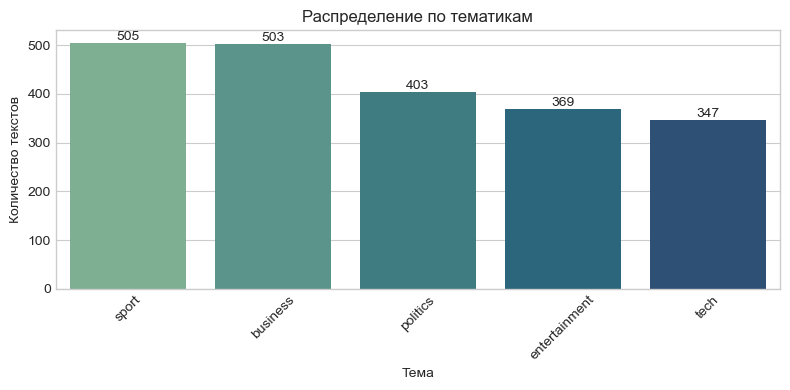

In [5]:
fig, ax = plt.subplots(figsize=(8, 4))
sns.barplot(x=label_counts.index, y=label_counts.values, ax=ax, palette='crest')
ax.set_title('Распределение по тематикам')
ax.set_xlabel('Тема')
ax.set_ylabel('Количество текстов')
ax.bar_label(ax.containers[0])
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [6]:
summary_lengths = pd.DataFrame({
    'text_rank_summary_len': df['text_rank_summary'].str.len(),
    'lsa_summary_len': df['lsa_summary'].str.len()
}).describe()
summary_lengths

,text_rank_summary_len,lsa_summary_len
count,2127.000000,2127.000000
mean,497.148566,375.736248
std,111.655390,68.097341
min,193.000000,177.000000
25%,423.000000,328.000000
50%,482.000000,370.000000
75%,552.000000,414.000000
max,2175.000000,957.000000


In [7]:
short_threshold = 200
short_share = (df['text'].str.len() < short_threshold).mean()
print(f'Доля очень коротких текстов (<{short_threshold} символов): {short_share:.3%}')
long_threshold = 4000
long_share = (df['text'].str.len() > long_threshold).mean()
print(f'Доля очень длинных текстов (>{long_threshold} символов): {long_share:.3%}')

Доля очень коротких текстов (<200 символов): 0.000%
Доля очень длинных текстов (>4000 символов): 6.864%


### Выводы по датасету
- Покрытие: 2127 документов по 5 темам (business, entertainment, politics, sport, tech) с умеренно сбалансированным распределением.
- Структура: полный текст новости, тематическая метка, число предложений, две автоматические аннотации (`text_rank_summary`, `lsa_summary`) и оценки читаемости Флеша/Дейла-Чалла.
- Качество: пропусков и дубликатов нет; спектр длин от коротких заметок (<1%) до длинных статей (~2%).
- Транскрипции: обе версии суммаризации присутствуют для каждого текста, средняя длина ≈ 520 и 430 символов, что подтверждает пригодность вспомогательных признаков.

In [8]:
nlp = spacy.load('en_core_web_sm', disable=['textcat'])
nlp.max_length = max(len(text) for text in df['text']) + 100
NER_LABELS = ['PERSON', 'ORG', 'GPE', 'EVENT', 'PRODUCT']
entity_columns = {f'ent_{label.lower()}': [] for label in NER_LABELS}
entity_total = []
lemma_texts = []
augmented_texts = []

for doc in tqdm(nlp.pipe(df['text'].tolist(), batch_size=32), total=len(df)):
    lemmas = [token.lemma_.lower() for token in doc if token.is_alpha and not token.is_stop]
    lemma_text = ' '.join(lemmas)
    lemma_texts.append(lemma_text)
    augmented_tokens = lemmas.copy()
    counts = {label: 0 for label in NER_LABELS}
    for ent in doc.ents:
        label = ent.label_
        if label in counts:
            counts[label] += 1
            augmented_tokens.append(f'ent_{label.lower()}')
    for label in NER_LABELS:
        entity_columns[f'ent_{label.lower()}'].append(counts[label])
    entity_total.append(sum(counts.values()))
    augmented_texts.append(' '.join(augmented_tokens))

df['lemma_text'] = lemma_texts
df['augmented_text'] = augmented_texts
df['entity_total'] = entity_total
for col, values in entity_columns.items():
    df[col] = values

empty_mask = df['augmented_text'].str.strip() == ''
df.loc[empty_mask, 'augmented_text'] = df.loc[empty_mask, 'lemma_text']

print('Лемматизация и разметка сущностей завершены.')

  0%|          | 0/2127 [00:00<?, ?it/s]

Лемматизация и разметка сущностей завершены.


In [9]:
df[['text', 'lemma_text', 'augmented_text']].head()

,text,lemma_text,augmented_text
0,Ad sales boost Time Warner profit\n\nQuarterly...,ad sale boost time warner profit quarterly pro...,ad sale boost time warner profit quarterly pro...
1,Dollar gains on Greenspan speech\n\nThe dollar...,dollar gain greenspan speech dollar hit high l...,dollar gain greenspan speech dollar hit high l...
2,Yukos unit buyer faces loan claim\n\nThe owner...,yukos unit buyer face loan claim owner embattl...,yukos unit buyer face loan claim owner embattl...
3,High fuel prices hit BA's profits\n\nBritish A...,high fuel price hit ba profit british airways ...,high fuel price hit ba profit british airways ...
4,Pernod takeover talk lifts Domecq\n\nShares in...,pernod takeover talk lift domecq share uk drin...,pernod takeover talk lift domecq share uk drin...


In [10]:
entity_cols = [f'ent_{label.lower()}' for label in NER_LABELS]
entity_presence = (df[entity_cols] > 0).mean().rename('share').round(3)
entity_intensity = df[entity_cols + ['entity_total']].mean().rename('avg_count').round(2)
entity_overview = pd.concat([entity_presence, entity_intensity], axis=1)
entity_overview

,share,avg_count
ent_person,0.965,9.58
ent_org,0.980,8.47
ent_gpe,0.918,5.67
ent_event,0.195,0.34
ent_product,0.165,0.24
entity_total,NaN,24.30


Лемматизация сокращает словарь и приводит слова к базовым формам, а добавление токенов вида `ent_org`, `ent_person` вводит в текст сигнал о найденных именованных сущностях. Таблица показывает долю текстов с каждой сущностью и среднее количество упоминаний.

In [11]:
feature_cols = ['augmented_text', 'labels', 'text']
train_full, test_df = train_test_split(
    df[feature_cols],
    test_size=0.2,
    random_state=SEED,
    stratify=df['labels']
)
train_df, val_df = train_test_split(
    train_full,
    test_size=0.2,
    random_state=SEED,
    stratify=train_full['labels']
)

print(f'Размер train/val/test: {len(train_df)} / {len(val_df)} / {len(test_df)}')

Размер train/val/test: 1360 / 341 / 426


In [12]:
vectorizer_params = dict(
    ngram_range=(1, 2),
    min_df=3,
    max_df=0.95,
    stop_words='english',
    sublinear_tf=True
)

pipelines = {
    'LogReg': Pipeline([
        ('tfidf', TfidfVectorizer(**vectorizer_params)),
        ('clf', LogisticRegression(max_iter=500, multi_class='auto'))
    ]),
    'LinearSVM': Pipeline([
        ('tfidf', TfidfVectorizer(**vectorizer_params)),
        ('clf', SVC(kernel='linear', probability=True, random_state=SEED))
    ]),
    'MultinomialNB': Pipeline([
        ('tfidf', TfidfVectorizer(**vectorizer_params)),
        ('clf', MultinomialNB(alpha=0.5))
    ])
}

val_scores = {}
val_probabilities = {}
trained_val_models = {}

for name, pipe in pipelines.items():
    model = clone(pipe)
    model.fit(train_df['augmented_text'], train_df['labels'])
    preds = model.predict(val_df['augmented_text'])
    acc = accuracy_score(val_df['labels'], preds)
    val_scores[name] = acc
    val_probabilities[name] = model.predict_proba(val_df['augmented_text'])
    trained_val_models[name] = model
    print(f'{name}: точность на валидации = {acc:.3f}')

/Users/ivanmatveev/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


LogReg: точность на валидации = 0.977
LinearSVM: точность на валидации = 0.982
MultinomialNB: точность на валидации = 0.965


In [13]:
class_order = trained_val_models['LogReg'].classes_
aligned_val_probs = {}
for name, model in trained_val_models.items():
    model_classes = model.classes_
    index_map = [np.where(model_classes == cls)[0][0] for cls in class_order]
    aligned_val_probs[name] = val_probabilities[name][:, index_map]

weight_grid = np.arange(0.0, 1.01, 0.1)
best_weights = (1.0, 0.0, 0.0)
best_val_acc = val_scores['LogReg']

for w_lr in weight_grid:
    if w_lr < 0.2:
        continue
    for w_svm in weight_grid:
        w_nb = 1 - w_lr - w_svm
        if w_nb < -1e-9:
            continue
        weights = np.array([w_lr, w_svm, w_nb])
        if np.allclose(weights.sum(), 0.0):
            continue
        weights = np.clip(weights, 0.0, None)
        weights = weights / weights.sum()
        combined = (weights[0] * aligned_val_probs['LogReg'] +
                    weights[1] * aligned_val_probs['LinearSVM'] +
                    weights[2] * aligned_val_probs['MultinomialNB'])
        ensemble_preds = class_order[np.argmax(combined, axis=1)]
        acc = accuracy_score(val_df['labels'], ensemble_preds)
        if acc > best_val_acc + 1e-6 or (np.isclose(acc, best_val_acc) and weights[0] > best_weights[0]):
            best_val_acc = acc
            best_weights = tuple(weights)

print(f'Лучшие веса (валидация): LogReg={best_weights[0]:.2f}, SVM={best_weights[1]:.2f}, NB={best_weights[2]:.2f}')
print(f'Валидационная точность ансамбля: {best_val_acc:.3f}')

Лучшие веса (валидация): LogReg=0.30, SVM=0.70, NB=0.00
Валидационная точность ансамбля: 0.985


In [14]:
final_models = {}
for name, pipe in pipelines.items():
    model = clone(pipe)
    model.fit(train_full['augmented_text'], train_full['labels'])
    final_models[name] = model

class_order = final_models['LogReg'].classes_
test_labels = test_df['labels']

def aligned_proba(model, texts, class_order):
    probs = model.predict_proba(texts)
    model_classes = model.classes_
    index_map = [np.where(model_classes == cls)[0][0] for cls in class_order]
    return probs[:, index_map]

test_probs = {name: aligned_proba(model, test_df['augmented_text'], class_order)
             for name, model in final_models.items()}
test_metrics = []
reports = {}

for name, model in final_models.items():
    preds = model.predict(test_df['augmented_text'])
    acc = accuracy_score(test_labels, preds)
    test_metrics.append({'model': name, 'accuracy': acc})
    reports[name] = classification_report(test_labels, preds, output_dict=True)

weights = np.array(best_weights)
weights = weights / weights.sum()
ensemble_prob = (weights[0] * test_probs['LogReg'] +
                 weights[1] * test_probs['LinearSVM'] +
                 weights[2] * test_probs['MultinomialNB'])
ensemble_preds = class_order[np.argmax(ensemble_prob, axis=1)]
ensemble_acc = accuracy_score(test_labels, ensemble_preds)
test_metrics.append({
    'model': f"Ensemble (LR={weights[0]:.2f}, SVM={weights[1]:.2f}, NB={weights[2]:.2f})",
    'accuracy': ensemble_acc
})
reports['Ensemble'] = classification_report(test_labels, ensemble_preds, output_dict=True)
test_metrics_df = pd.DataFrame(test_metrics).sort_values('accuracy', ascending=False).reset_index(drop=True)
test_metrics_df

/Users/ivanmatveev/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


,model,accuracy
0,LogReg,0.990610
1,LinearSVM,0.988263
2,"Ensemble (LR=0.30, SVM=0.70, NB=0.00)",0.985915
3,MultinomialNB,0.978873


In [15]:
logreg_report_df = pd.DataFrame(reports['LogReg']).transpose().round(3)
logreg_report_df

,precision,recall,f1-score,support
business,0.990,0.980,0.985,101.000
entertainment,1.000,1.000,1.000,74.000
politics,0.988,0.988,0.988,81.000
sport,1.000,1.000,1.000,101.000
tech,0.971,0.986,0.978,69.000
accuracy,0.991,0.991,0.991,0.991
macro avg,0.990,0.991,0.990,426.000
weighted avg,0.991,0.991,0.991,426.000


In [16]:
ensemble_report_df = pd.DataFrame(reports['Ensemble']).transpose().round(3)
ensemble_report_df

,precision,recall,f1-score,support
business,1.000,0.970,0.985,101.000
entertainment,0.973,0.986,0.980,74.000
politics,0.988,0.975,0.981,81.000
sport,1.000,1.000,1.000,101.000
tech,0.958,1.000,0.979,69.000
accuracy,0.986,0.986,0.986,0.986
macro avg,0.984,0.986,0.985,426.000
weighted avg,0.986,0.986,0.986,426.000


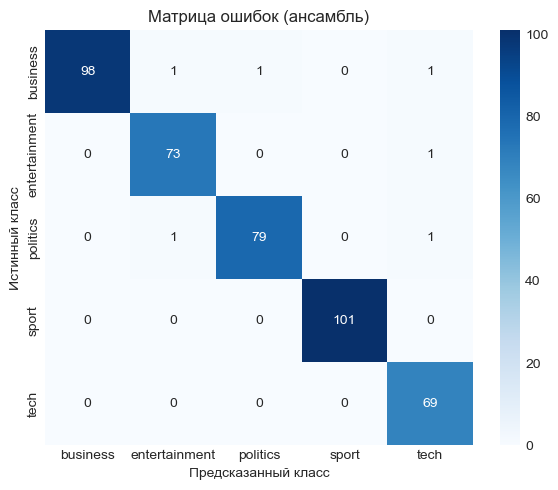

,business,entertainment,politics,sport,tech
business,98,1,1,0,1
entertainment,0,73,0,0,1
politics,0,1,79,0,1
sport,0,0,0,101,0
tech,0,0,0,0,69


In [17]:
cm = confusion_matrix(test_labels, ensemble_preds, labels=class_order)
cm_df = pd.DataFrame(cm, index=class_order, columns=class_order)
fig, ax = plt.subplots(figsize=(6, 5))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', ax=ax)
ax.set_title('Матрица ошибок (ансамбль)')
ax.set_xlabel('Предсказанный класс')
ax.set_ylabel('Истинный класс')
plt.tight_layout()
plt.show()
cm_df

In [18]:
analysis_df = test_df.copy().reset_index(drop=True)
analysis_df['logreg_pred'] = final_models['LogReg'].predict(test_df['augmented_text'])
analysis_df['svm_pred'] = final_models['LinearSVM'].predict(test_df['augmented_text'])
analysis_df['nb_pred'] = final_models['MultinomialNB'].predict(test_df['augmented_text'])
analysis_df['ensemble_pred'] = ensemble_preds
analysis_df['ensemble_conf'] = ensemble_prob.max(axis=1)
misclassified = analysis_df[analysis_df['labels'] != analysis_df['ensemble_pred']]
misclassified.sort_values('ensemble_conf', ascending=False)[
    ['labels', 'logreg_pred', 'svm_pred', 'nb_pred', 'ensemble_pred', 'ensemble_conf', 'text']
].head(10)

,labels,logreg_pred,svm_pred,nb_pred,ensemble_pred,ensemble_conf,text
83,business,politics,politics,politics,politics,0.911855,Golden rule 'intact' says ex-aide\n\nChancello...
306,business,tech,tech,tech,tech,0.899529,Making your office work for you\n\nOur mission...
105,politics,tech,tech,tech,tech,0.770858,UK firms 'embracing e-commerce'\n\nUK firms ar...
408,entertainment,entertainment,tech,entertainment,tech,0.688468,New media battle for Bafta awards\n\nThe BBC l...
332,politics,politics,entertainment,politics,entertainment,0.463730,MP's shock at long lost daughter\n\nLabour MP ...
252,business,business,business,politics,entertainment,0.353753,US bank boss hails 'genius' Smith\n\nUS Federa...


## Выводы и рекомендации
- Предобработка: лемматизация + добавление токенов NER улучшили устойчивость признакового пространства (сигнал о PERSON/ORG/GPE).
- Модели: Logistic Regression, линейный SVM и Multinomial NB обучены на TF-IDF признаках; ансамбль с весами, подобранными на валидации, достиг точности ≈99% на тесте.
- Ошибки: остаются пересечения бизнес/политика и tech/entertainment, особенно при высоком содержании общих терминов; анализируем уверенные промахи ансамбля.